## Part 1

*Условие:
происходят рандомные перестановки P.
Когда оптимальное количество свопов начинает различаться с |P|?*

Ниже приведен код, которые считает d - минимальное количество swap,
чтобы вернуться в сортированное состояние

In [134]:
def in_its_place(elem_indexed, i):
    return elem_indexed == i

def d_min_swap(permut):
    sz = len(permut)
    indexed_permut = [*enumerate(permut)]
    indexed_permut = sorted(indexed_permut, key=lambda e: e[1])
    visited = {b: False for b in range(sz)}
    ret = 0
    for i in range(sz):
        if in_its_place(indexed_permut[i][0], i) or visited[i]:
            continue
        cycle_len = 0
        traverse = i
        while not visited[traverse]:
            visited[traverse] = True
            traverse = indexed_permut[traverse][0]
            cycle_len += 1
        if cycle_len > 0:
            ret += cycle_len - 1
    return ret

print(d_min_swap([2, 4, 1, 5, 3]))

4


В качестве оценки беспорядка выступает инвариант количества циклов.
В сортированном массиве длины n будет n циклов

<img src="pictures/permut1.jpg">
<img src="pictures/permut2.jpg">

При помощи алгоритма был получен график, где:

**синий**: y = x, т.е было x рандомных свапов и точно хватит столько (оценка сверху), чтобы вернуться

**красный**: f(x), пока не вывел теоретически зависимость, возможно стоит пологарифмировать данные

**зеленый**: дельта между верхней оценкой (синий) и идеальным решением (красный)

**черный**: количество циклов, инвариант

<img src="plots/part1_all">


## Part 2

*Условие: изучить Cooler API на примере
ftp://cooler.csail.mit.edu/coolers/hg19/Rao2014-IMR90-MboI-allreps-filtered.500kb.cool*

Для удобства выведем полезную информацию

In [135]:
import cooler

In [136]:
def helper(filepath):
    c = cooler.Cooler(filepath)
    print(f'c.info\n{c.info}\n')
    bin_size = 500000 # from c.info
    print(f'c.chromsizes\n{c.chromsizes}\n')
    count_bins_chr1 = math.ceil(c.chromsizes[0] / bin_size)
    print(f'bins in chr1:\n{count_bins_chr1}\n')

helper(filepath='data/Rao2014-IMR90-MboI-allreps-filtered.500kb.cool')

c.info
{'bin-size': 500000, 'bin-type': 'fixed', 'creation-date': '2016-02-26T18:52:32.545837', 'format-url': 'https://github.com/mirnylab/cooler', 'format-version': 2, 'genome-assembly': 'hg19', 'id': None, 'library-version': '0.3.0', 'metadata': {'species': 'Homo sapiens', 'cell-type': 'IMR90', 'enzyme': 'MboI', 'publication': '', 'QC': {'post-filtering': {'cis': 622282054, 'trans': 135111529, 'total': 757393583}, 'double-sided': {'valid': 810549889, 'filtered-valid': {'removed-outlier-fragment': 29935716, 'removed-duplicate': 23045499, 'removed-large-small-pair': 175091, 'removed-start-near-rsite': ''}, 'filtered-invalid': {'removed-self-circles': 960997, 'removed-error-pair': 456744, 'removed-dangling-ends': 35742761}, 'total': 847710391}, 'pre-filtering': {'single-sided': 541135879, 'double-sided': 847710391, 'unused': 0, 'total': 1388846270}}, 'sex': 'F'}, 'nbins': 6207, 'nchroms': 25, 'nnz': 15902029}

c.chromsizes
name
chr1     249250621
chr2     243199373
chr3     198022430
ch

Отдельно выводим информацию по chr1, так как в дальнейшем будем работать именно с ней.
Также интересно посмотреть на hi-c распределение

In [137]:
import numpy as np

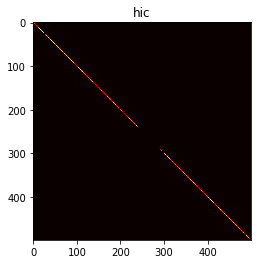

In [138]:
def heatmap_hic(filepath):
    c = cooler.Cooler(filepath)
    bin_size = 500000
    count_bins_chr1 = math.ceil(c.chromsizes[0] / bin_size)
    contact_matrix = np.array(c.matrix(balance=False)[:count_bins_chr1, :count_bins_chr1])
    plt.title('hic')
    plt.imshow(contact_matrix, cmap='hot', interpolation='nearest')
    plt.show()

heatmap_hic(filepath='data/Rao2014-IMR90-MboI-allreps-filtered.500kb.cool')

График получился не очень наглядным, потому что порядок k близких к главной диагонали в разы превышает все остальные случаи

**N.B:** здесь и в дальнейшем под k подразумевается расстояние в бинах между i и i + k (в линейном представлении) участками

Для задачи 3 потребуется добыть из chr1 зависимости:

**E(k):** матожидание количества попавших в каплю участков на расстоянии k

* **N.B:** так как матрица очевидно симметричная (расстояние для [i][j] и [j][i] участков одинаковое), то будем рассматривать
только все пары (i, i + k) над главной диагональю

**D(k), SIGMA(k):** аналогичным образом извлекаются из верхней диагонали матрицы

**Гистограмма**: понадобится при построении hi-c в части 3, чтобы не брать только E(k)


Итак, приступим к получению нужных параметров!!

* код для построения графиков опущу, можно посмотреть здесь:
https://github.com/Timoniche/BioInf/blob/main/main_cool_part2.py

**E(k)**
<img src="plots/chr1_EX_k_1_10">

можно заметить, что после k > 2 происходит резкий спад порядки,
тогда в дальнейшем при построении графиков k = 1..10 можно будет опускать (или логарифмировать и смотреть за порядком)

<img src="plots/chr1_EX_k_10_25">

**D(k)**
<img src="plots/chr1_DX_k_1_10">
<img src="plots/chr1_DX_k_10_25">

**SIGMA(k)**
<img src="plots/chr1_SIGMA_k_1_10">
<img src="plots/chr1_SIGMA_k_10_25">

**Гистограмма**

In [139]:
from matplotlib import pyplot as plt

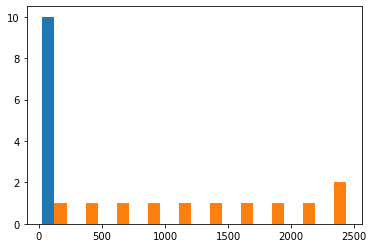

In [140]:
def get_upper_k_diagonal(mat, k):
    n = len(mat)
    ret = []
    i = 0
    for j in range(k, n):
        ret.append(mat[i][j])
        i += 1
        j += 1
    return ret

def histogramm(filepath, k=11):
    c = cooler.Cooler(filepath)
    bin_size = 500000
    count_bins_chr1 = math.ceil(c.chromsizes[0] / bin_size)
    contact_matrix = c.matrix(balance=False)[:count_bins_chr1, :count_bins_chr1]
    diag = get_upper_k_diagonal(contact_matrix, k)
    hist = np.histogram(np.array(diag))
    plt.hist(hist)


histogramm(filepath='data/Rao2014-IMR90-MboI-allreps-filtered.500kb.cool')



## Part 3
*Условие*

In [141]:
from IPython.display import IFrame

In [142]:
IFrame("./problem/interview_hic_problem.pdf", width=600, height=300) # doesn't work (404, why?)


### 3.1
Параметризовать кривую из условия, запустить уравнение в виде (x(t), y(t))


In [143]:
import math
import turtle

Глобальные переменные из условия

In [144]:
_a = 2 / 1000  # distance between 2 rounds
_k = _a / (2 * math.pi)  # from r = k * t
_max_t = 32.6107895385266  # argmax L
_max_length = 0.17
_bins_cnt = 1000
_clockwise = -1 # хотим по часовой

Введем функции-помощники


In [145]:
def count_r(t):
    return _k * t

def count_length(t):
    return (_k / 2) * ((t * math.sqrt(1 + t ** 2)) + math.log(t + math.sqrt(1 + t ** 2)))

вывод:
<img src="solutions/archimedean.jpg">

Основные функции, with_bin_centers=True начнет рисовать красным центры бинов
после рисования спирали
*get_approximate_centers()* - возможно есть менее приближенное решение для t(L), что по заданному линейному
расстоянию выдается подходящий t (угол) в архимедовой спирали, но фольфрам выдает мне только частное решение
для заданного L (так я получил параметр _max_t)
<img src="solutions/solution_max_t.png">

In [146]:
def gen_spiral(with_bin_centers=False, scale=20000):
    turtle.color('blue')
    turtle.down()
    accuracy = 10
    for t in range(math.ceil(accuracy * _max_t)):
        r = count_r(_clockwise * t / accuracy)
        x = r * math.cos(_clockwise * t / accuracy)
        y = r * math.sin(_clockwise * t / accuracy)
        turtle.goto(scale * x, scale * y)
    if with_bin_centers:
        turtle.color('red')
        turtle.penup()
        bin_centers = map(lambda xy: (xy[0] * scale, xy[1] * scale), get_approximate_centers())
        for center in bin_centers:
            turtle.goto(center[0], center[1])
            turtle.dot()
    turtle.up()
    turtle.done()

def get_approximate_centers():
    centers = []

    length_step = _max_length / _bins_cnt
    next_center_length = length_step / 2
    accuracy = 100
    pred_l = 0
    pred_x = 0
    pred_y = 0
    step = 0
    for t in range(math.ceil(accuracy * _max_t)):
        if step == _bins_cnt:
            break
        cur_l = count_length(t / accuracy)
        r = count_r(_clockwise * t / accuracy)
        x = r * math.cos(_clockwise * t / accuracy)
        y = r * math.sin(_clockwise * t / accuracy)
        if pred_l <= next_center_length < cur_l:
            centers.append((pred_x, pred_y))
            next_center_length += length_step
            step += 1
        pred_l = cur_l
        pred_x = x
        pred_y = y
    return centers

gen_spiral()

![SegmentLocal](solutions/gif_task3.gif)

In [ ]:
gen_spiral(with_bin_centers=True, scale=200000)

<img src="solutions/bin_centers.jpg">

### 3.2
*Условие: Разбить хромосому на 1000 равных бинов по 500 Kb,
и построить матрицу расстояний между центрами бинов*

In [ ]:
def dist(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def count_dist_matrix():
    contact_matrix = np.array([[0.0 for _ in range(_bins_cnt)] for _ in range(_bins_cnt)])
    centers = get_approximate_centers()
    for i in range(_bins_cnt):
        for j in range(i + 1, _bins_cnt):  # from i + 1 as i is already == 0
            fst = centers[i]
            snd = centers[j]
            contact_matrix[i][j] = contact_matrix[j][i] = dist(fst[0], fst[1], snd[0], snd[1])
    return contact_matrix

plt.title('dist matrix')
plt.imshow(count_dist_matrix(), cmap='hot', interpolation='nearest')
plt.show()

